# Pneumonia Detection

## Imports and device-agnostic code


In [1]:
import torch
from torch import nn

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
if device == 'cuda':
  !nvidia-smi

Mon Apr 17 12:02:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data


In [12]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'chest_xray/chest_xray'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else: 
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download x-ray scans data
with open(data_path / 'chest_xray.zip', 'wb') as f:
  request = requests.get('https://github.com/eliaszpiotr/PneumoniaDetection/raw/main/data/chest_xray.zip')
  print('Downloading data...')
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / 'chest_xray.zip', 'r') as zip_ref:
  print('Unzipping data...')
  zip_ref.extractall(image_path)

data/chest_xray/chest_xray directory already exists... skipping download
Unzipping data...


## Data preparation and exploration

In [13]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path and returning its content.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`.')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in `data/chest_xray`.
There are 3 directories and 1 images in `data/chest_xray/chest_xray`.
There are 2 directories and 1 images in `data/chest_xray/chest_xray/test`.
There are 0 directories and 234 images in `data/chest_xray/chest_xray/test/NORMAL`.
There are 0 directories and 390 images in `data/chest_xray/chest_xray/test/PNEUMONIA`.
There are 2 directories and 1 images in `data/chest_xray/chest_xray/val`.
There are 0 directories and 9 images in `data/chest_xray/chest_xray/val/NORMAL`.
There are 0 directories and 9 images in `data/chest_xray/chest_xray/val/PNEUMONIA`.
There are 2 directories and 1 images in `data/chest_xray/chest_xray/train`.
There are 0 directories and 1342 images in `data/chest_xray/chest_xray/train/NORMAL`.
There are 0 directories and 3876 images in `data/chest_xray/chest_xray/train/PNEUMONIA`.
There are 1 directories and 1 images in `data/chest_xray/__MACOSX`.
There are 3 directories and 4 images in `data/chest_xray/__MACOSX/c

In [14]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

train_dir, test_dir, val_dir

(PosixPath('data/chest_xray/chest_xray/train'),
 PosixPath('data/chest_xray/chest_xray/test'),
 PosixPath('data/chest_xray/chest_xray/val'))

## Visualizing and image

In [15]:
image_path

PosixPath('data/chest_xray/chest_xray')

data/chest_xray/chest_xray/train/PNEUMONIA/person1239_bacteria_3195.jpeg
Random image path: data/chest_xray/chest_xray/train/PNEUMONIA/person1239_bacteria_3195.jpeg
Image class: PNEUMONIA
Image height: 648
Image width: 848


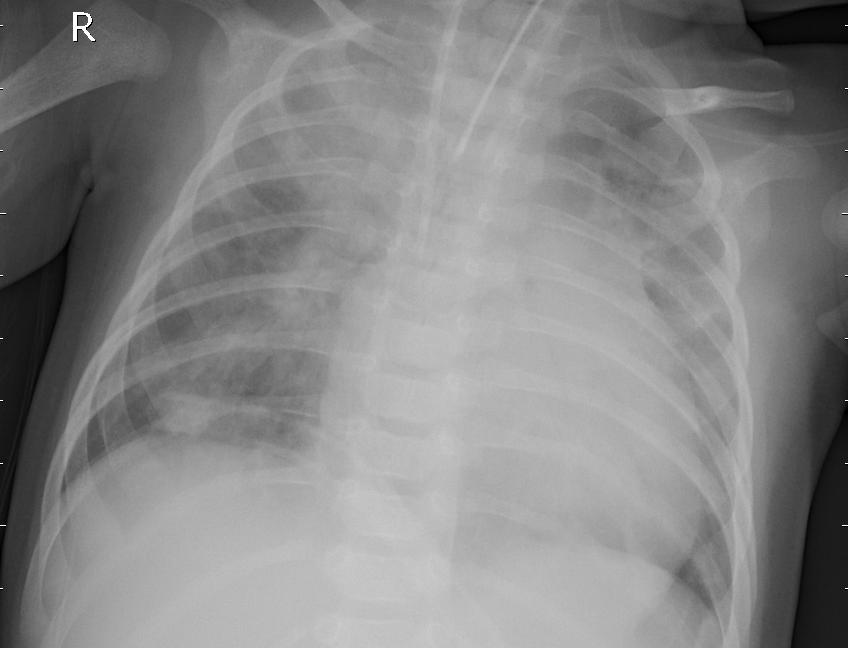

In [20]:
import random 
from PIL import Image

# Set random seed
# random.seed(42)

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpeg"))

# 2. Pick a random image path 
random_image_path = random.choice(image_path_list)
print(random_image_path)


# 3. Get image class from name path (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
image_class

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

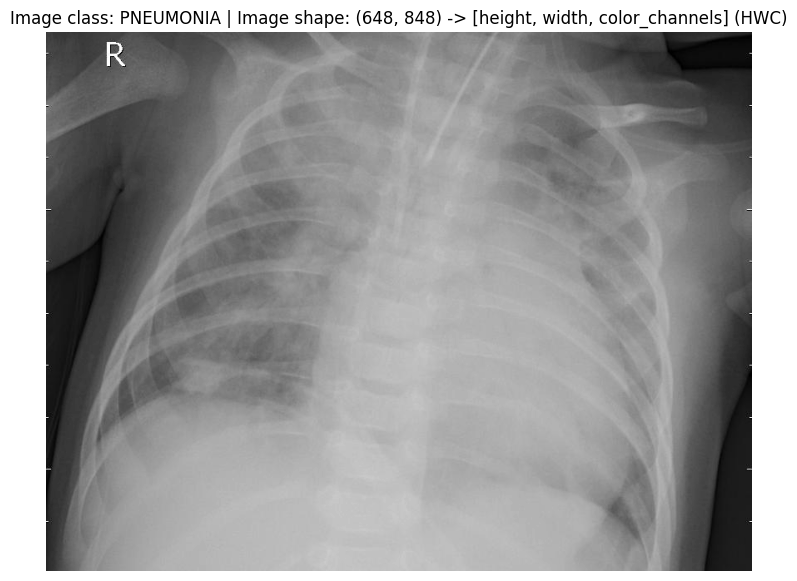

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image to an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array, cmap='gray')
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)')
plt.axis(False);

## Transforming data

In [23]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transform`

In [40]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the iimage into a torch.Tensor
    transforms.ToTensor()
])

In [41]:
data_transform(img)

tensor([[[0.2392, 0.2314, 0.2353,  ..., 0.1098, 0.0784, 0.0588],
         [0.2588, 0.2549, 0.2510,  ..., 0.0392, 0.0392, 0.0392],
         [0.2745, 0.2627, 0.2549,  ..., 0.0510, 0.0510, 0.0667],
         ...,
         [0.1961, 0.3059, 0.4275,  ..., 0.1059, 0.1137, 0.1137],
         [0.2039, 0.3098, 0.4196,  ..., 0.1059, 0.1137, 0.1176],
         [0.2039, 0.3059, 0.4118,  ..., 0.1059, 0.1137, 0.1176]]])

In [42]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f, cmap='gray')
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image, cmap='gray')
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

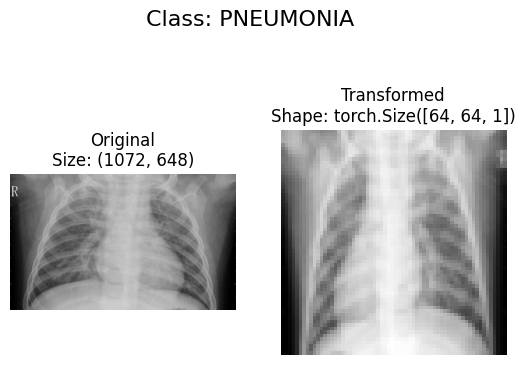

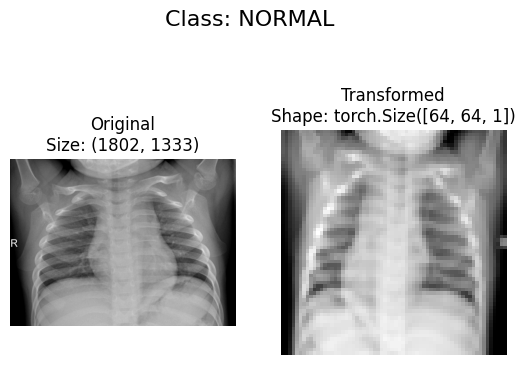

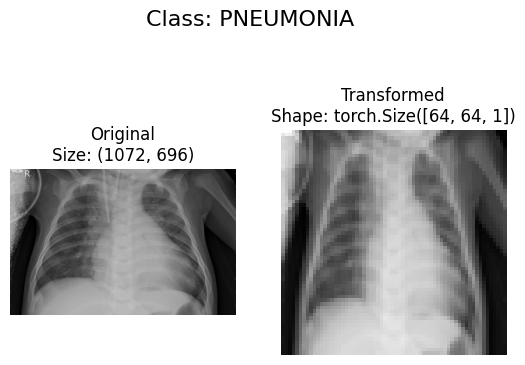

In [44]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)